# Aim

Implement turbulence fitting in the frequency domain.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import welch
from scipy import stats, optimize
import sys
from tqdm import tqdm
import warnings

sys.path.append("..")
from src import SystemIdentifier
from src import genpsd
from src.controllers.identifier import log_likelihood
from src.utils import rms

Running in simulation mode.
Recomputed interaction matrix and command matrix


/Users/adityasengupta/research/ao/set-tt-control/notebooks/../src/optics/image.py:109: UserWarning: Exposure time in sim optics is not used yet.
  warnings.warn("Exposure time in sim optics is not used yet.")
/Users/adityasengupta/research/ao/set-tt-control/notebooks/../src/optics/image.py:117: UserWarning: Image propagation from the DM has not been implemented.
  warnings.warn("Image propagation from the DM has not been implemented.")


In [2]:
ol = np.load("../data/tt_center_noise/tt_center_noise_nsteps_10000_delay_0.01_dt_21_07_2021_12.npy")

In [96]:
# first, try to replicate Meimon 2010's Figure 7
nsteps = 100000
ident = SystemIdentifier(ol[:2000], fs=1)
# kvals = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1, 2, 5, 10]
kvals = [0.001, 0.05, 0.2, 0.4, 0.8, 2, 5]
freqs = np.arange(0.01, 10.0, 0.01)

def make_A(k, f):
    a1 = 2 * np.exp(-2*k*np.pi*f / ident.fs) * np.cos(2*np.pi*f/(ident.fs * np.sqrt((1 - k**2)+0j)))
    a2 = -np.exp(-4*k * np.pi * f / ident.fs)
    return a1, a2

100%|██████████| 7/7 [00:01<00:00,  3.85it/s]


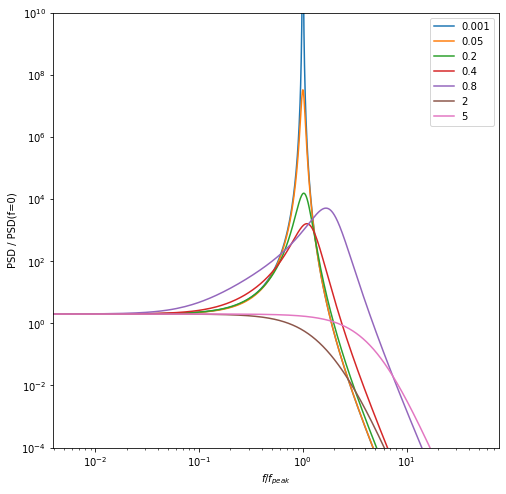

In [108]:
plt.figure(figsize=(8,8))
x0 = [1, 0]
fpeak = 0.01
with np.errstate(invalid="ignore"):
    for k in tqdm(kvals):
        a1, a2 = make_A(k, fpeak)
        states = np.zeros((nsteps,))
        states[:2] = x0
        for i in range(2, nsteps):
            states[i] = a1 * states[i-1] + a2 * states[i-2]# + 1e-4 * np.random.randn()

        f, p = genpsd(states, dt=1, remove_dc=False)
        plt.loglog(f / fpeak, p / p[0], label=k)
    plt.xlabel(r"$f / f_{peak}$")
    plt.ylabel("PSD / PSD(f=0)")
    plt.ylim(1e-4, 1e10)
    plt.legend()

So I can do that, cool. I'm convinced that a turbulence pattern can be fit well by the same damped-exp modes we've been using for vibrations. Now to do it.

(cells redacted)

this doesn't work

let's just fit an AR process

In [3]:
ident = SystemIdentifier(ol)
klqg = ident.make_klqg_ar(ar_len=4)
klqg.recompute()

Solved discrete ARE.
Solved discrete ARE.
Solved discrete ARE.
Solved discrete ARE.
Solved discrete ARE.
Solved discrete ARE.
Solved discrete ARE.
Solved discrete ARE.


In [327]:
from scipy.stats import multivariate_normal as mvn
process_dist = mvn(cov=klqg.W, allow_singular=True)

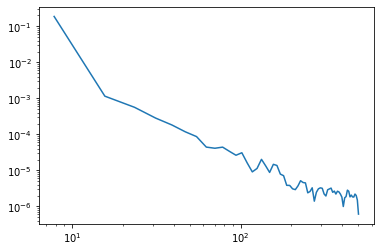

In [328]:
plt.loglog(*genpsd(klqg.sim_process()[:,0], dt=1e-3))

In [329]:
rms(klqg.sim_process(nsteps=1000))

1.6802

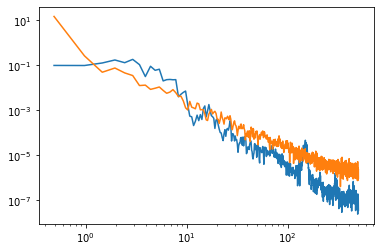

In [330]:
plt.loglog(f, p)
plt.loglog(*genpsd(klqg.sim_process(nsteps=10000)[:,0], dt=1e-3))

In [331]:
rms(klqg.sim_control(nsteps=1000))

0.0657

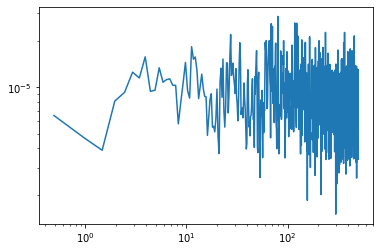

In [332]:
plt.loglog(*genpsd(klqg.sim_control(nsteps=10000)[:,0], dt=1e-3))

In [334]:
p

array([9.65657106e-02, 9.58802947e-02, 1.24154163e-01, ...,
       6.38895897e-08, 4.50886811e-08, 3.62152662e-08])

In [9]:
kl = ident.make_klqg_turb(np.abs(np.fft.ifft(np.fft.fftshift(p))))

In [4]:
f, p = genpsd(ol[:,0], dt=1e-3)

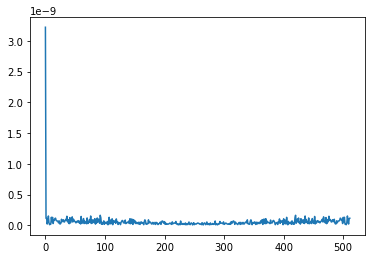

In [7]:
plt.plot(np.abs(np.fft.ifft(np.fft.fftshift(p)[:len(p)//2])))